In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os

In [79]:

def decode_image(img):
    resized=cv2.resize(img,(256,256))
    reshaped=resized.reshape(1,256,256,3)
    scaled=(np.array(reshaped)/127.5)-1
    
    return scaled


    

In [80]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
       result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [81]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [82]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [83]:
from keras.models import load_model
model_generator=Generator()
model_generator.load_weights("monet_generator (1).h5")


In [84]:

prediction=model_generator.predict(decode_image(img))
monet_img=(prediction*127.5+127.5).reshape(256,256,3)

2022-07-26 08:37:58.621165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [85]:

model_generator.save("monet_generator.model")

INFO:tensorflow:Assets written to: monet_generator.model/assets


In [86]:
prediction

array([[[[ 2.3315682e-01, -2.3076020e-03, -4.6204332e-01],
         [ 3.8422105e-01,  6.2081427e-03, -6.5178478e-01],
         [ 4.2347655e-01,  1.3428188e-02, -6.4010161e-01],
         ...,
         [ 6.4556319e-01,  5.0758308e-01,  1.1249947e-01],
         [ 6.4273787e-01,  5.1213485e-01,  1.9023138e-01],
         [ 4.9552828e-01,  4.0861434e-01,  1.7755029e-01]],

        [[ 3.6072508e-01,  1.7253739e-03, -6.3318282e-01],
         [ 4.8810941e-01, -2.5582723e-02, -7.2591341e-01],
         [ 5.3988153e-01,  3.2996655e-02, -7.7235150e-01],
         ...,
         [ 7.2876096e-01,  5.5847818e-01,  1.3662843e-01],
         [ 7.1205717e-01,  5.8434987e-01,  2.3121381e-01],
         [ 6.2780768e-01,  5.2537119e-01,  2.2324277e-01]],

        [[ 4.1180965e-01, -1.7636474e-03, -6.7504275e-01],
         [ 5.2636290e-01, -6.4900896e-04, -7.6614213e-01],
         [ 6.1730355e-01,  3.4006096e-02, -7.9791468e-01],
         ...,
         [ 7.2134101e-01,  5.6981570e-01,  9.6124083e-02],
         [

In [87]:
monet_img

array([[[157.2275  , 127.20578 ,  68.58948 ],
        [176.48819 , 128.29153 ,  44.397438],
        [181.49326 , 129.2121  ,  45.887047],
        ...,
        [209.8093  , 192.21684 , 141.84369 ],
        [209.44908 , 192.7972  , 151.7545  ],
        [190.67986 , 179.59833 , 150.13766 ]],

       [[173.49245 , 127.719986,  46.769188],
        [189.73395 , 124.238205,  34.946037],
        [196.3349  , 131.70708 ,  29.025185],
        ...,
        [220.41702 , 198.70596 , 144.92012 ],
        [218.2873  , 202.00461 , 156.97977 ],
        [207.54547 , 194.48483 , 155.96346 ]],

       [[180.00574 , 127.27513 ,  41.432053],
        [194.61127 , 127.41725 ,  29.81688 ],
        [206.2062  , 131.83578 ,  25.765877],
        ...,
        [219.47098 , 200.1515  , 139.75581 ],
        [218.91077 , 200.75038 , 153.54784 ],
        [208.66017 , 194.64444 , 155.29935 ]],

       ...,

       [[116.07697 , 121.11157 , 127.44662 ],
        [146.92407 , 152.61322 , 160.96721 ],
        [180.08423 , 1

In [88]:
monet_img=np.array(monet_img,dtype="uint8")

In [89]:
monet_img

array([[[157, 127,  68],
        [176, 128,  44],
        [181, 129,  45],
        ...,
        [209, 192, 141],
        [209, 192, 151],
        [190, 179, 150]],

       [[173, 127,  46],
        [189, 124,  34],
        [196, 131,  29],
        ...,
        [220, 198, 144],
        [218, 202, 156],
        [207, 194, 155]],

       [[180, 127,  41],
        [194, 127,  29],
        [206, 131,  25],
        ...,
        [219, 200, 139],
        [218, 200, 153],
        [208, 194, 155]],

       ...,

       [[116, 121, 127],
        [146, 152, 160],
        [180, 183, 190],
        ...,
        [179, 130,  41],
        [172, 131,  43],
        [160, 129,  60]],

       [[ 89,  96,  97],
        [ 72,  77,  82],
        [ 91,  92,  97],
        ...,
        [169, 122,  39],
        [159, 118,  41],
        [148, 115,  57]],

       [[ 97, 103, 102],
        [ 70,  78,  77],
        [ 71,  75,  73],
        ...,
        [161, 122,  50],
        [153, 120,  52],
        [140, 118,  70]]

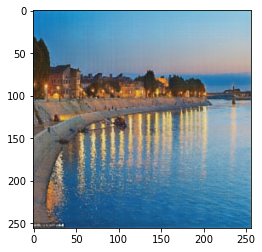

In [90]:
rgb_monet = cv2.cvtColor(monet_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_monet,cmap = plt.cm.Spectral)

plt.savefig("painting.png")
plt.savefig("painting.pdf")
#plt.imshow(rgb, cmap = plt.cm.Spectral)

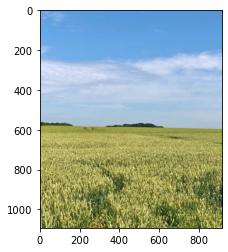

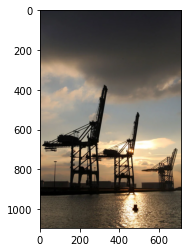

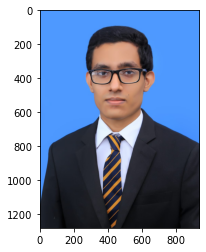

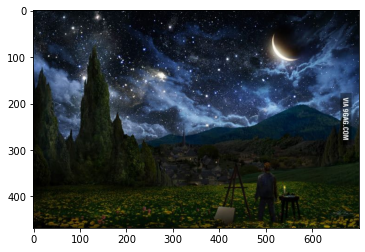

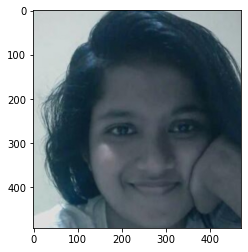

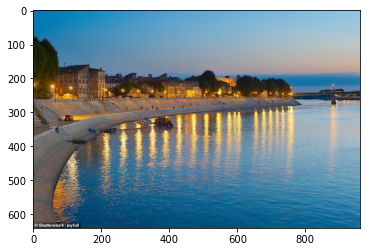

In [109]:
img_dir="/Users/kumara/Desktop/machine learning /deep learning projects/unsupervised/Adding Monet styles to photoes using CycleGAN/testing images"
img_names=os.listdir(img_dir)
for img_name in img_names:
    if img_name!='.DS_Store':
        img_path=os.path.join(img_dir,img_name)
        img=cv2.imread(img_path)
        img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        plt.imshow(img_rgb)
        plt.show()
    

In [95]:
img_names

['van gogh wheatfields copy.tiff',
 'testing images',
 'photo-sunset-sky-beautiful-orange-sky-above-dark-forest-sunset-two-suns-photo-sunset-sky-two-souls-two-suns-118123764.jpeg',
 'photo_generator (1).h5',
 '.DS_Store',
 'monet paintings',
 'painting.pdf',
 'painting.png',
 'van gogh wheatfields.webp',
 'Colab_Monet_CycleGAN_testing.ipynb',
 'monet_generator.model',
 'monet_generator (1).h5',
 '.ipynb_checkpoints',
 'monet-cyclegan-tutorial (5).ipynb',
 'sunset.pdf',
 'sunset.png']

In [101]:
img_path=os.path.join(img_dir,'van gogh wheatfields copy.tiff')

In [104]:
img=cv2.imread(img_path)

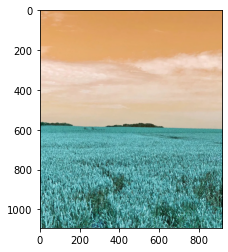

In [105]:
plt.imshow(img)

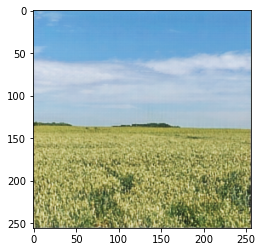

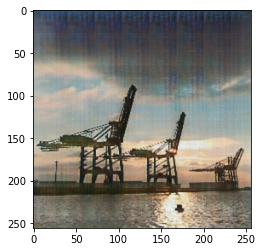

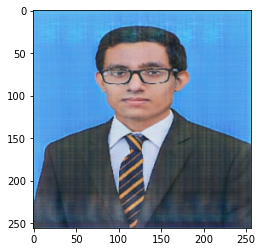

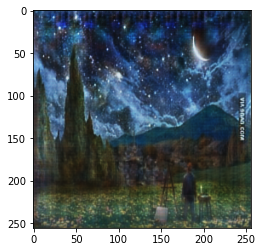

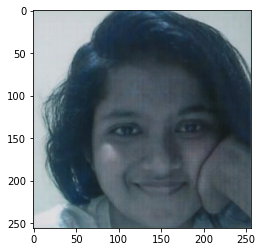

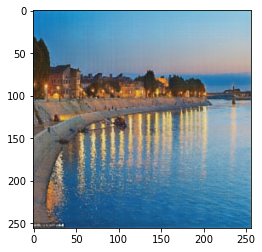

In [115]:
for counter,img_name in enumerate(img_names):
    if img_name!='.DS_Store':
        img_path=os.path.join(img_dir,img_name)
        img=cv2.imread(img_path)
        prediction=model_generator.predict(decode_image(img))
        monet_img=(prediction*127.5+127.5).reshape(256,256,3)
        monet_img=np.array(monet_img,dtype="uint8")
        monet_img=cv2.cvtColor(monet_img,cv2.COLOR_BGR2RGB)
        plt.imshow(monet_img)
        plt.savefig("{}.jpeg".format(counter))
        plt.show()